#  How to obtain ideal Bandwidths

Based on kde_tutorial from https://notebooks.gesis.org/binder/jupyter/user/saint-germain-p-ation_synthesis-uu00810x/tree/prep

### Libraries and data
The data trataiment:

In [1]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
dn=pd.read_csv('proc_no_pert.csv',index_col=None) #without pertubtations 
dn["gia"]=dn.ngi>0
dl=pd.read_csv('proc_lo_pert.csv',index_col=None) #with low pertubtations 
dl["gia"]=dl.ngi>0
dh=pd.read_csv('proc_hi_pert.csv',index_col=None) #with high pertubtations 
dh["gia"]=dh.ngi>0

In [5]:
#Terrestrial
dnt=dn[~dn["gia"]] # without pertubtations 
dlt=dl[~dl["gia"]] # low pertubtations 
dht=dh[~dh["gia"]] # high pertubtations 

#Giant 
dng=dn[dn["gia"]]  # without pertubtations 
dlg=dl[dl["gia"]]  # low pertubtations 
dhg=dh[dh["gia"]]  # high without pertubtations 

In [6]:
print("***************************************")
print("Total systems                  : "+str(len(dn)))
print("***************************************")
print("Total planets - no             : "+str(dn.nplanets.sum().astype(int)))
print("Giant planets - no             : "+str(dn.ngi.sum().astype(int)))
print("Systems with giant planets - no: "+str(dn.gia.sum()))
print("***************************************")

print("Total planets - lo             : "+str(dl.nplanets.sum().astype(int)))
print("Giant planets - lo             : "+str(dl.ngi.sum().astype(int)))
print("Systems with giant planets - lo: "+str(dl.gia.sum()))
print("***************************************")
print("Total planets - hi             : "+str(dh.nplanets.sum().astype(int)))
print("Giant planets - hi             : "+str(dh.ngi.sum().astype(int)))
print("Systems with giant planets - hi: "+str(dh.gia.sum()))

***************************************
Total systems                  : 1221
***************************************
Total planets - no             : 15887
Giant planets - no             : 330
Systems with giant planets - no: 268
***************************************
Total planets - lo             : 15732
Giant planets - lo             : 374
Systems with giant planets - lo: 306
***************************************
Total planets - hi             : 15441
Giant planets - hi             : 388
Systems with giant planets - hi: 309


Some important variables: 

In [7]:
#log_10 of mass efficiency and center of mass
#log_10 mass efficiency giant and terrestrial 
dng['logeff']=np.log10(dng.massefficiency)
dlg['logeff']=np.log10(dlg.massefficiency)
dhg['logeff']=np.log10(dhg.massefficiency)
dnt['logeff']=np.log10(dnt.massefficiency)
dlt['logeff']=np.log10(dlt.massefficiency)
dht['logeff']=np.log10(dht.massefficiency)#
#log_10 total mass efficiency
dn['logeff']=np.log10(dn.massefficiency)
dl['logeff']=np.log10(dl.massefficiency)
dh['logeff']=np.log10(dh.massefficiency)

#log_10 total com
dn['logcom']=np.log10(dn.com)
dl['logcom']=np.log10(dl.com)
dh['logcom']=np.log10(dh.com)

#log_10 com giant and terrestrial 
dng['logcom']=np.log10(dng.com)
dlg['logcom']=np.log10(dlg.com)
dhg['logcom']=np.log10(dhg.com)
dnt['logcom']=np.log10(dnt.com)
dlt['logcom']=np.log10(dlt.com)
dht['logcom']=np.log10(dht.com)

In [8]:
dng.head()

,Unnamed: 0,ident,com,nplanets,massbudget,massefficiency,sigmag0,md,rc,ms,metal,taugas,qest,ngi,mtr,apert,gia,logeff,logcom
0,0,3.0,1.081461,10.0,10770.309627,0.576981,90.793337,0.056,29.539343,0.880114,0.328146,1644710.625,8.421395,4.0,12.004623,0.0,True,-0.238839,0.034011
2,2,6.0,0.110789,12.0,2422.342359,0.060559,75.740878,0.120,47.343380,0.861595,0.021273,1790533.125,4.412694,1.0,29.771089,0.0,True,-1.217824,-0.955504
4,4,13.0,0.172211,13.0,2905.457535,0.051273,178.830700,0.170,36.672222,1.206445,-0.174039,3956707.500,3.998513,1.0,14.220447,0.0,True,-1.290113,-0.763939
16,16,31.0,4.377862,11.0,41.578462,0.001299,86.546084,0.096,39.613728,0.993549,-0.031508,1439538.875,5.991912,1.0,17.716253,0.0,True,-2.886282,0.641262
23,23,40.0,2.144859,13.0,181.982608,0.006578,57.698437,0.083,45.111870,1.037112,0.039315,2374519.750,7.413428,1.0,14.782324,0.0,True,-2.181927,0.331399


## Bandwidth problem
So far we have our data. Now we need to construct their probability density distributions. To do this we employ Kernel Density Estimation (KDE), here the bandwidth take importance. Let's study how to estimate the shape $\widehat{f}_{h}(x)$ of the funtion which could represents the probability density function: 

$$\widehat{f}_{h}(x)=\frac{1}{n} \sum_{i=1}^{n} K_{h}\left(x-x_{i}\right)=\frac{1}{n h} \sum_{i=1}^{n} K\left(\frac{x-x_{i}}{h}\right).$$

Here $K_{h}$ is a kernel (non-negative function), commonly used: uniform, triangular, biweight, triweight, Epanechnikov, normal, among others. The $h$ parameters is a smoothing constant, it is also called _bandwidth_ (mor information of KDE <a href="https://cran.r-project.org/web/packages/kedd/vignettes/kedd.pdf">here</a>). 
 

### The Bandwidth definition
A very brief definition, from <a href="https://en.wikipedia.org/wiki/Kernel_density_estimation">wikipedia</a>: The bandwidth of the kernel is a free parameter which exhibits a strong influence on the resulting estimate. T

he most common optimality criterion used to select this parameter is the expected risk function employing cross validation: 

$$\operatorname{MISE}(h)=\mathrm{E}\left[\int\left(\hat{f}_{h}(x)-f(x)\right)^{2} d x\right].$$

Also is used the rule-of-thumb bandwidth estimator:

$$h=\left(\frac{4 \hat{\sigma}^{5}}{3 n}\right)^{\frac{1}{5}} \approx 1.06 \hat{\sigma} n^{-1 / 5}.$$

Or Silverman's (1986) rule of thumb:

$$h=0.9 \min \left(\hat{\sigma}, \frac{I Q R}{1.34}\right) n^{-\frac{1}{5}}.$$

Some considrations in the values of $h$. On the one hand, if $h\rightarrow 0$ then we have overfitting, in other words there is no smoothing (plots like sum of delta fuctions).  On the other hand, if $h\rightarrow \infty$, we have a density function completily smoothed.

Now, let's estudy some examples with `cross_validation` and `gaussian_kde`: 

In [9]:
# an example with kernel density
x=dng.ngi
grid = GridSearchCV(KernelDensity(), 
                    {'bandwidth': np.linspace(x.min(),x.max()/100,100)},
                    cv=50) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

# other example with gaussian_kde method. 
kde = gaussian_kde(x)
f = kde.covariance_factor()
bw = f * x.std()
print("bw g_kde: "+str(bw))

{'bandwidth': 0.04}
bw g_kde: 0.17399675736725956


A comparison plot

(array([2.71144279, 0.        , 0.        , 0.49751244, 0.        ,
        0.        , 0.09950249, 0.        , 0.        , 0.02487562]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

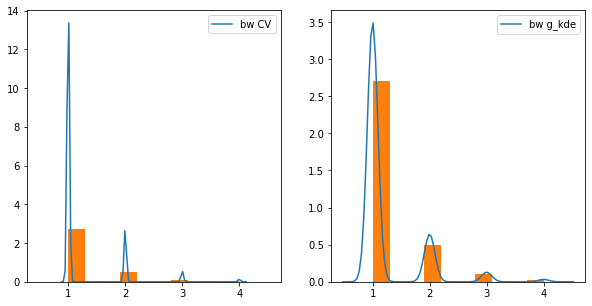

In [10]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

sns.kdeplot(dng.ngi, bw=grid.best_params_['bandwidth'], ax=axes[0], label="bw CV"); 
axes[0].hist(dng.ngi, density=True)

sns.kdeplot(dng.ngi,bw=bw, ax=axes[1],label="bw g_kde"); 
axes[1].hist(dng.ngi, density=True)

Now we introduce a new funtoion that obtain the bandwidths through `Gaussian_kde` and `CrossValidation`. Then, the optimal bandwidhts came from `bw_opt` function:

In [11]:
#The variable is a column from dataFrames: 'dng','dlg','dhg','dnt','dlt','dht','dn','dl','dh'
def bw_opt(variable, name, plot=False):

    m=.2; dvariable=0.05; deciamls=2
    
    x = variable/variable.min() 
    x_grid = np.around(np.arange(x.min()-m,x.max()+m,dvariable),deciamls)
    norm, size, cv = 10, 30, 30 # 30-fold cross-validation     
        
    #-------------With CrossValidation:
    #x = 
    grid = GridSearchCV(KernelDensity(), 
                        {'bandwidth': np.linspace(x.min(),x.max()/\
                                                  norm,size)},
                        cv=cv) # max-min (grid)
    grid.fit(x[:, None])
    kde_CV = grid.best_estimator_
    bw_CV  = list(grid.best_params_.values())[0]
    pdf_CV = np.exp(kde_CV.score_samples(x_grid[:,None]))
    
    #-------------Gaussian_KDE:
    kde_G = gaussian_kde(x)
    f = kde.covariance_factor()
    bw_KDE =  f * x.std()
    pdf_kde = kde_G.evaluate(x_grid)
    
    #---------Comparative plot: 
    if plot == True: 
        fig, ax = plt.subplots(1,3, figsize=(11, 4), constrained_layout=True, sharex=True, sharey=True)
        #-------CV_plot:
        ax[0].plot(x_grid, pdf_CV, linewidth=2, label='bw=%.4f'%kde_CV.bandwidth)
        ax[0].hist(x,8,density=True, alpha=.3)
        ax[0].legend(loc="upper right")
        ax[0].set_title("Cross Validation")
        #-------kde_plot:
        ax[1].plot(x_grid, pdf_kde, linewidth=2, label='bw=%.4f'%bw_KDE)
        ax[1].hist(x,8,density=True, alpha=.3)
        ax[1].legend(loc="upper right")
        ax[1].set_title("Gausian_kde")
        #-------sns_plot:
        sns.distplot(x,  ax=ax[2], axlabel=False, bins=8,
                     hist_kws={"alpha": .3, "color": 'C1'}, 
                     label='default distplot') 
        ax[2].legend(loc="upper right")
        ax[2].set_title("displot")
        #---------------
        fig.suptitle("variable: "+name, 
                     fontsize=15, horizontalalignment='center')
        plt.show()
    return [bw_CV, bw_KDE]

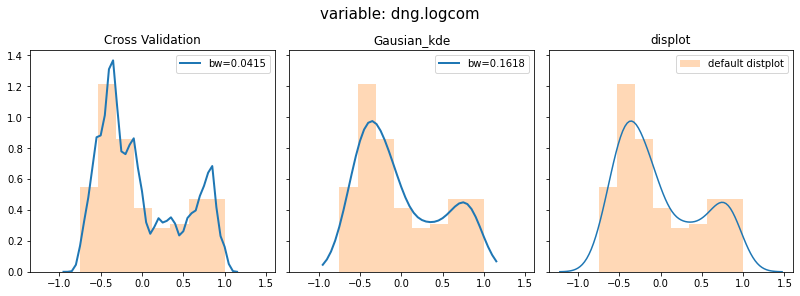

In [12]:
dng_logcom = bw_opt(dhg.logcom, name="dng.logcom", plot=True)

dng.logeff


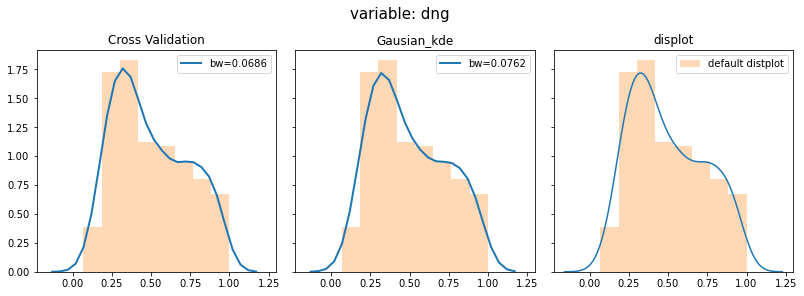

dlg.logeff


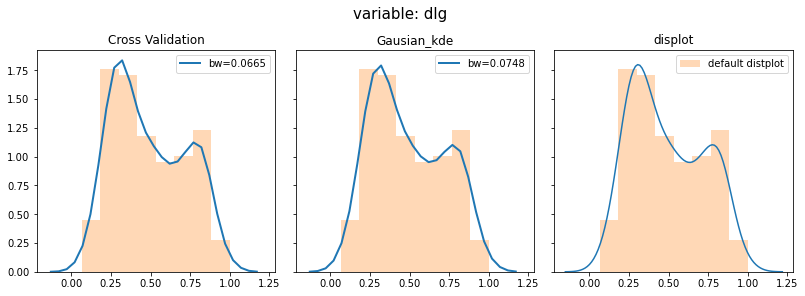

dhg.logeff


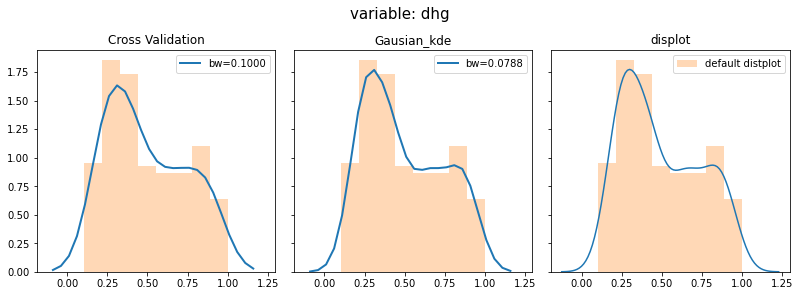

dnt.logeff


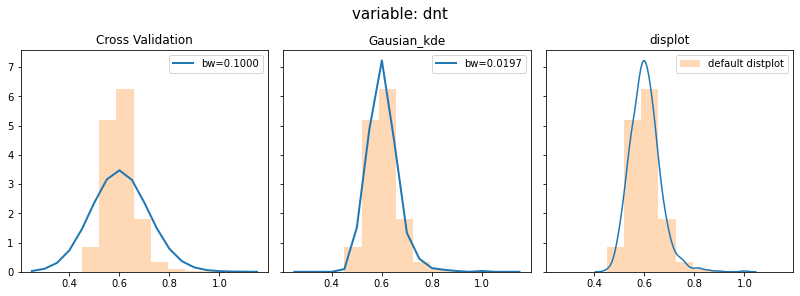

dlt.logeff


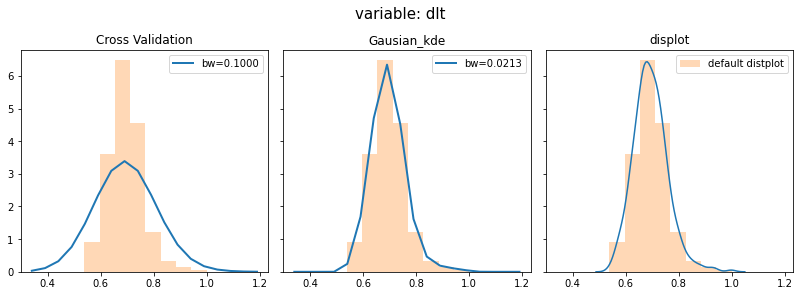

dht.logeff


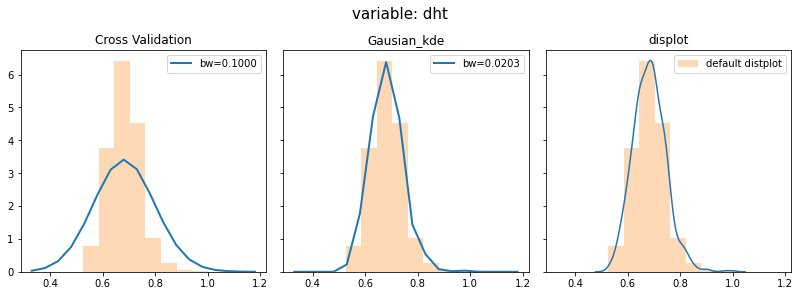

dn.logeff


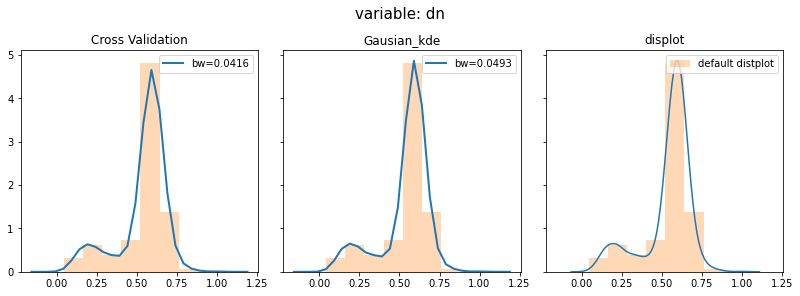

dl.logeff


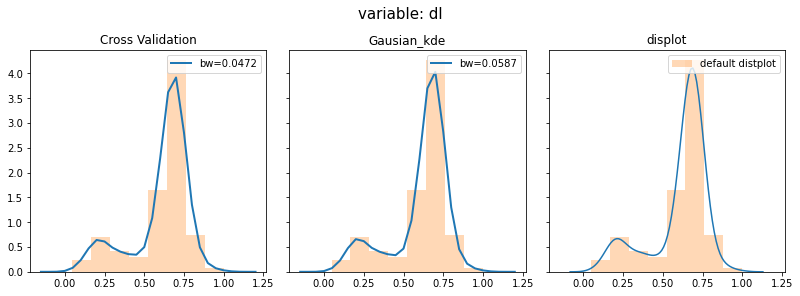

dh.logeff


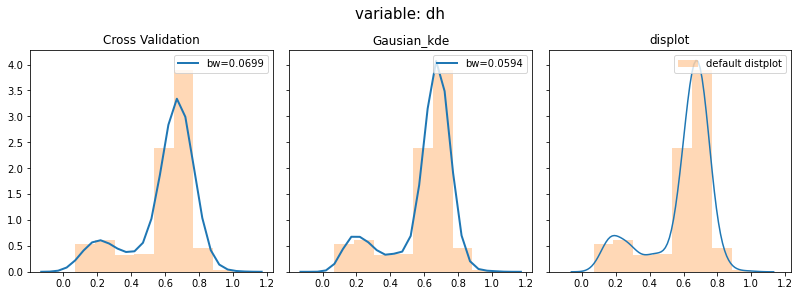

In [60]:
#%%time
x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]
names       = ["dng","dlg","dhg","dnt","dlt","dht","dn","dl","dh"]
opt_bw_eff  = [] 
##opt_bw_logcom  = [] 

for index,variable in enumerate(x_variables):
    print(names[index]+"."+str(variable.logeff.name))
    bw = bw_opt(variable.logeff, names[index], plot=True)
    opt_bw_eff.append(bw)



### Using the standarization and normalization

Now, through phyton classes we implements the `GridSearchCV` and `gaussian_kde` as methods of a class `bw_optimal` with th normalization and the standarization of the data. Let's remember some definitions:

- **Normalization**: It is a scaling technique in which values are shifted and rescaled so that they end up ranging between 0 to 1.  
$$X^{\prime}=\frac{X-X_{\min }}{X_{\max }-X_{\min }}$$

- **Standarization**: It is another scaling technique where the values are centered around the mean with a unit standard deviation. 
$$X^{\prime}=\frac{X-\mu}{\sigma}$$

In order to compare the data, we implement normalization and standarization.




#### The minimum distance between data

To obtain de ideal bandwith, we estimate the minimun distance between our data to star from this value to 


It is obtained through the minimum difference between data. It helps to understand the minumum bandwidth for the distribution. It is implementend into the init method in the class `bw_optimal`.

We generate a determine number of bins 

In [80]:
class bw_optimal(object):
    
    def __init__(self, variable, norm=True):
        
        dx, length, deciamls = .2, 100, 2 #some variables
        n_data = 10                       #optimal numer of data per bin
    
        if norm == True:#norm_variable:
            self.x = (variable.values-variable.values.min())/\
            (variable.values.max()-variable.values.min())
        else: #stardarization variable:     
            self.x = (variable.values-variable.values.mean())/variable.values.std()
       
        self.x_grid = np.around(np.linspace(self.x.min()-dx,self.x.max()+dx,
                                           length),deciamls)
        
        self.nbins = round(len(self.x)/n_data)
        self.dw = (np.unique(self.x)[1:]-np.unique(self.x)[:-1]).min()
    
    def cv_pdf(self):
        cv = 30
        grid = GridSearchCV(KernelDensity(), 
                        {'bandwidth': np.linspace(self.dw,
                                                  self.x.max(),
                                                  self.nbins)}, cv=cv)
        grid.fit(self.x[:, None])
        
        self.kde_CV = grid.best_estimator_
        self.bw_CV  = list(grid.best_params_.values())[0]
        self.pdf_CV = np.exp(self.kde_CV.score_samples(self.x_grid[:,None]))

    def kde_pdf(self):
        kde_G = gaussian_kde(self.x)
        f = kde.covariance_factor()
        self.bw_KDE =  f * self.x.std()
        self.pdf_kde = kde_G.evaluate(self.x_grid)

In [88]:
#needs an object from class bw_optimal
def pdfs_plot(bw):
    
    fig, ax = plt.subplots(1,2, figsize=(10, 4), constrained_layout=True, sharex=True, sharey=True)

    ax[0].plot(bw.x_grid, bw.pdf_CV, linewidth=2, label='bw=%.4f'%bw.kde_CV.bandwidth)
    ax[0].hist(bw.x, bw.nbins,density=True, alpha=.3, label=str(bw.nbins))
    ax[0].legend(loc="upper right")
    ax[0].set_title("Cross Validation")

    ax[1].plot(bw.x_grid, bw.pdf_kde, linewidth=2, label='bw=%.4f'%bw.bw_KDE)
    ax[1].hist(bw.x,bw.nbins,density=True, alpha=.3, label=str(bw.nbins))
    ax[1].legend(loc="upper right")
    ax[1].set_title("Gausian_kde")

    plt.show()

In [91]:
ex = bw_optimal(dlt.logeff, False)
ex.cv_pdf()
ex.kde_pdf()

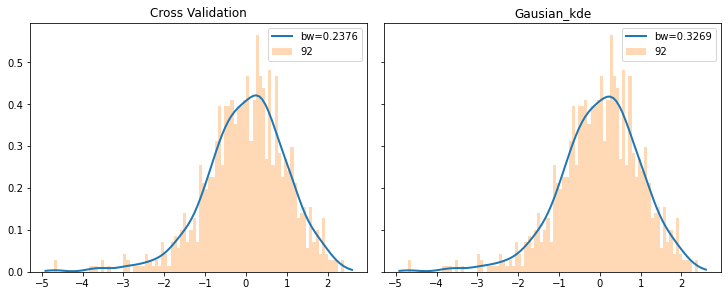

In [92]:
plot = pdfs_plot(ex)

In [18]:
len(dnt.logeff)/10

95.3

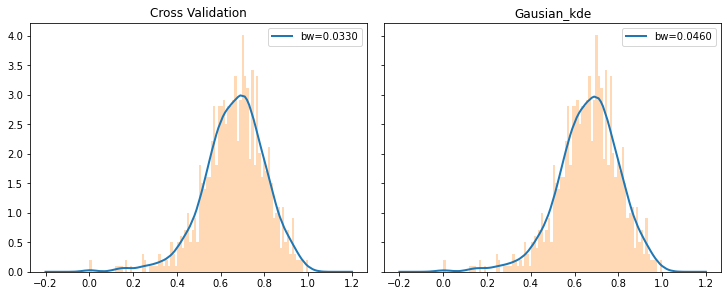

In [79]:
plot = pdfs_plot(ex)

In [20]:
class pfd_plots(bw_optimal):
    
    def __init__(self, variable, size, norm=True):
        bw_optimal.__init__(self,variable, size, norm=True)
        self.cv_pdf()
        self.kde_pdf()
        #plot_pdf()
        
    def plot_pdf(self):
        
        fig, ax = plt.subplots(1,3,figsize=(12, 4), 
                               constrained_layout=True, 
                               sharex=True, sharey=True)
        #-------CV_plot:
        ax[0].plot(self.x_grid, self.pdf_CV, linewidth=2, 
                label='bw=%.5f'%self.kde_CV.bandwidth)
        ax[0].hist(self.x, density=True, alpha=.3)
        ax[0].legend(loc="upper right"); ax[0].set_title("Cross Validation")
        #-------kde_plot:
        ax[1].plot(self.x_grid, self.pdf_kde, linewidth=2, label='bw=%.5f'%self.bw_KDE)
        ax[1].hist(self.x, density=True, alpha=.3)
        ax[1].legend(loc="upper right"); ax[1].set_title("Gausian_kde")    
        #-------sns_plot:
        sns.distplot(self.x,  ax=ax[2], axlabel=False,
                     hist_kws={"alpha": .3, "color": 'C1'}, label='default distplot', 
                    kde_kws={'bw':0.029462576409423447}) 
        ax[2].legend(loc="upper right"); ax[2].set_title("displot")
        
        plt.show()

In [21]:
A_plots = pfd_plots(dnt.logeff, 100,False)
A_plots.plot_pdf()

TypeError: __init__() got multiple values for argument 'norm'

In [ ]:
AA = np.unique(dnt.logeff.values)
AA[1:]-AA[:-1]

In [ ]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
digits = load_digits()

# project the 64-dimensional data to a lower dimension
pca = PCA(n_components=15, whiten=False)
data = pca.fit_transform(digits.data)

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

In [ ]:
variable = dng.logeff.values

norm_variable = (variable-variable.min())/(variable.max()-variable.min())

#norm_variable = (variable-variable.mean())/variable.std()
#norm_variable
#sns.distplot(norm_variable)
#normal_variable = preprocessing.normalize().fit(variable[:,None])

In [ ]:
#variable = dng.logcom
deciamls=2
nbins = 15    
#x = variable/variable.min() 

x_grid = np.around(np.linspace(norm_variable.min()-.2,
                               norm_variable.max()+.2,100),
                   deciamls)
norm, size, cv = 10, 30, 30 # 30-fold cross-validation     

wbins = (norm_variable.max()-norm_variable.min())/(nbins+1)
print(wbins)
#-------------With CrossValidation:
#x = 
grid = GridSearchCV(KernelDensity(), 
                    {'bandwidth': np.linspace(2*wbins,
                                              5*wbins,50)}, cv=cv) # max-min (grid)
grid.fit(norm_variable[:, None])
kde_CV = grid.best_estimator_
bw_CV  = list(grid.best_params_.values())[0]
pdf_CV = np.exp(kde_CV.score_samples(x_grid[:,None]))

In [ ]:
#np.linspace(norm_variable.min(),norm_variable.max(),100)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4, 4), constrained_layout=True, sharex=True, sharey=True)
ax.plot(x_grid, pdf_CV, linewidth=2, label='bw=%.4f'%kde_CV.bandwidth)
ax.hist(norm_variable,15,density=True, alpha=.3)
ax.legend(loc="upper right")
ax.set_title("Cross Validation")

In [ ]:
len(norm_variable)

In [ ]:
kde_G = gaussian_kde(norm_variable)
f = kde.covariance_factor()
bw_KDE =  f * norm_variable.std()
pdf_kde = kde_G.evaluate(x_grid)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4, 4), constrained_layout=True, sharex=True, sharey=True)
ax.plot(x_grid, pdf_kde, linewidth=2, label='bw=%.4f'%bw_kde)
ax.hist(norm_variable,15,density=True, alpha=.3)
ax.legend(loc="upper right")
ax.set_title("Gausian_kde")

In [ ]:
sns.distplot(norm_variable, bins=20)

In [ ]:
dng_logeff = bw_opt(dng.logeff, name="dng.logeff", plot=True)

Now, for all the variables

In [ ]:
#%%time
opt_bw_com      = [] 
#opt_bw_logcom  = [] 

for index,variable in enumerate(x_variables):
    print(names[index]+"."+str(variable.logcom.name))
    bw = bw_optimal(variable.logcom, names[index], plot=True)
    opt_bw_com.append(bw)

The comparative plot for the log_10 of efficiency

## Bandwiths for  2D, 3D and mode dimensions

### 2D Example
For 2d, we have the function:

In [ ]:
def uni_kde(x,y,tickno=5,nlev=30):
    
    x_grid=np.around(np.arange(x.min(),x.max(),0.1),2)
    y_grid=np.linspace(y.min(),y.max(),len(x_grid))
    conv=(x.max()-x.min())/(y.max()-y.min())
    yori=y
    y=y*conv
    y_grid=y_grid*conv
    
    grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(x.min(),x.max()/10,30)},
                    cv=20) # 20-fold cross-validation
    
    grid.fit(np.vstack([x,y]).T)
    print(grid.best_params_)
    
    X, Y = np.meshgrid(x_grid, y_grid)
  
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    
    kde2d = grid.best_estimator_
    pdf2d = np.exp(kde2d.score_samples(xy)).reshape(X.shape) #get the pdf
    
    plt.figure(figsize=(5,5))
    levels = np.linspace(0, pdf2d.max(), nlev)
    plt.contourf(X, Y, pdf2d, levels=levels, cmap=plt.cm.Reds)
    
    old_ticks=np.linspace(y.max(), y.min(), tickno)
    major_ticks = 10**np.linspace(yori.max(), yori.min(), tickno)
    myticks=[]
    for i in major_ticks:
        myticks+=["%.e"%i]
    e=plt.yticks(old_ticks,myticks) 

In [ ]:
uni_kde(dng.logcom,dng.logeff)

### 3D example

In [ ]:
from mpl_toolkits import mplot3d
#---------------------Data:
x = dng.logeff/dng.logeff.min()
y = dng.logcom#/dng.logcom.min()
z = dng.nplanets

data = np.vstack((x,y,z)).T

#---------------------Grid:
x_grid=np.around(np.arange(x.min(),x.max(),0.1),2)
y_grid=np.linspace(y.min(),y.max(),len(x_grid))
z_grid=np.linspace(z.min(),z.max(),len(x_grid))

X,Y,Z = np.meshgrid(x_grid, y_grid, z_grid)
xyz   = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

#----------------------CV:

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(x.min(),x.max()/10,30)},
                    cv=20) # 20-fold cross-validation
grid.fit(data)

    
kde3d = grid.best_estimator_
pdf3d = np.exp(kde3d.score_samples(xyz)).reshape(X.shape) #get the pdf

In [ ]:
density = pdf3d.ravel()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
x, y, z = X.ravel(), Y.ravel(), Z.ravel()
ax.scatter(x, y, z, c=density, alpha=1, cmap= 'seismic',
           vmin=-np.abs(np.max(density)),vmax=np.abs(np.max(density)))

In [ ]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=density.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=25, # needs to be a large number for good volume rendering
    ))
fig.show()

In [ ]:
#-------------Gaussian_KDE:
'''
kde_G = gaussian_kde(data)
f = kde.covariance_factor()
bw_KDE =  f * data.std()
pdf3_kde = kde_G.evaluate(xyz)
pdf3_kde = kde_G.evaluate()
'''